In [1]:
!pip install -q transformers datasets accelerate scikit-learn sentencepiece

In [2]:
#importing the necessary libraries
import torch
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from transformers import BigBirdTokenizer, BigBirdForSequenceClassification, Trainer, TrainingArguments



2026-01-18 15:21:57.145672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768749717.352008      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768749717.409612      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768749717.885854      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768749717.885895      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768749717.885899      24 computation_placer.cc:177] computation placer alr

In [3]:
df = pd.read_csv('../input/mbti_1.csv')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
#removing URLs and punctuation from dataset
# 1. Replace '|||' with a space (mimics the split/join logic)
df['posts'] = df['posts'].str.replace(r'\|\|\|', ' ', regex=True)

# 2. Remove URLs
df['posts'] = df['posts'].str.replace(r"http\S+", "", regex=True)

# 3. Remove punctuation and numbers
df['posts'] = df['posts'].str.replace(r"[-/@.?!_,:;()|0-9]", "", regex=True)

# 4. Remove extra whitespace (mimics the split('  ') logic but more robust)
df['posts'] = df['posts'].str.replace(r"\s+", " ", regex=True).str.strip()

df.head(10)



,type,posts
0,INFJ,' enfp and intj moments sportscenter not top t...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one Of course to which I say I know that...
3,INTJ,'Dear INTP I enjoyed our conversation the othe...
4,ENTJ,'You're fired That's another silly misconcepti...
5,INTJ,' Science is not perfect No scientist claims t...
6,INFJ,'No I can't draw on my own nails haha Those we...
7,INTJ,'I tend to build up a collection of things on ...
8,INFJ,I'm not sure that's a good question The distin...
9,INTP,' I'm in this position where I have to actuall...


In [5]:
def prepare_mbti_labels(df):
    # I/E: Introversion (0) / Extroversion (1)
    df['IE'] = df['type'].apply(lambda x: 0 if x[0] == 'I' else 1)
    # N/S: Intuition (0) / Sensing (1)
    df['NS'] = df['type'].apply(lambda x: 0 if x[1] == 'N' else 1)
    # T/F: Thinking (0) / Feeling (1)
    df['TF'] = df['type'].apply(lambda x: 0 if x[2] == 'T' else 1)
    # J/P: Judging (0) / Perceiving (1)
    df['JP'] = df['type'].apply(lambda x: 0 if x[3] == 'J' else 1)
    return df

In [6]:
df = prepare_mbti_labels(df)
MAX_LEN = 3000
model_name = "google/bigbird-roberta-base"
tokenizer = BigBirdTokenizer.from_pretrained(model_name)


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/846k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [7]:

# Dataset class
class MBTIDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

# Custom Trainer sửa lỗi num_items_in_batch
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Chuyển class_weights sang thiết bị (CPU/GPU) phù hợp
        self.class_weights = torch.tensor(class_weights).float().to(self.args.device)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs): # Thêm **kwargs ở đây
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Cấu hình Loss function với trọng số lớp
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)

        # Tính toán loss
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

In [8]:
from sklearn.metrics import f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"f1": f1_score(labels, preds)}

In [9]:
import matplotlib.pyplot as plt

def plot_loss(log_history, title="Training and Validation Loss"):
    train_loss = []
    eval_loss = []
    train_epochs = []
    eval_epochs = []

    for entry in log_history:
        # Kiểm tra xem có dữ liệu loss và epoch không
        if 'loss' in entry and 'epoch' in entry:
            train_loss.append(entry['loss'])
            train_epochs.append(entry['epoch'])
        
        # Kiểm tra xem có dữ liệu eval_loss và epoch không
        if 'eval_loss' in entry and 'epoch' in entry:
            eval_loss.append(entry['eval_loss'])
            eval_epochs.append(entry['epoch'])

    plt.figure(figsize=(10, 6))
    
    # Vẽ Training Loss
    if train_loss:
        plt.plot(train_epochs, train_loss, label='Training Loss', alpha=0.6, linestyle='--')
    
    # Vẽ Validation Loss
    if eval_loss:
        # Thường Validation Loss được tính ở cuối mỗi epoch, nên dùng marker để dễ nhìn
        plt.plot(eval_epochs, eval_loss, label='Validation Loss', marker='o', linewidth=2)

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.show()

In [10]:
# 1. Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['posts'], df['NS'], test_size=0.2, random_state=42
)

# 2. Tokenize
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=MAX_LEN)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=MAX_LEN)

train_dataset = MBTIDataset(train_encodings, list(train_labels))
val_dataset = MBTIDataset(val_encodings, list(val_labels))

# 3. Class weights
weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

# 4. Train
model_ns = BigBirdForSequenceClassification.from_pretrained(model_name, num_labels=2)

training_args = TrainingArguments(
    output_dir='/kaggle/working/results_ns',
    num_train_epochs=4,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    learning_rate=2e-6,
    lr_scheduler_type="cosine",
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    fp16=True,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
)

trainer_ns = WeightedTrainer(
    model=model_ns,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    class_weights=weights,
    compute_metrics=compute_metrics
)

trainer_ns.train()

# 5. Report & Save
preds = trainer_ns.predict(val_dataset).predictions.argmax(-1)
print("Classification Report for N/S:")
print(classification_report(val_labels, preds, target_names=['N', 'S']))

trainer_ns.save_model('/kaggle/working/model_mbti_NS')


pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/513M [00:00<?, ?B/s]

Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at google/bigbird-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Input ids are automatically padded from 2088 to 2112 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 2088 to 2112 to be a multiple of `config.block_size`: 64
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.627800,0.719416,0.000000
2,0.618500,0.730649,0.000000
3,0.602000,0.714240,0.000000
4,0.592900,0.707401,0.000000


Input ids are automatically padded from 2136 to 2176 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 2136 to 2176 to be a multiple of `config.block_size`: 64
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but

Classification Report for N/S:
              precision    recall  f1-score   support

           N       0.86      1.00      0.92      1489
           S       0.00      0.00      0.00       246

    accuracy                           0.86      1735
   macro avg       0.43      0.50      0.46      1735
weighted avg       0.74      0.86      0.79      1735



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


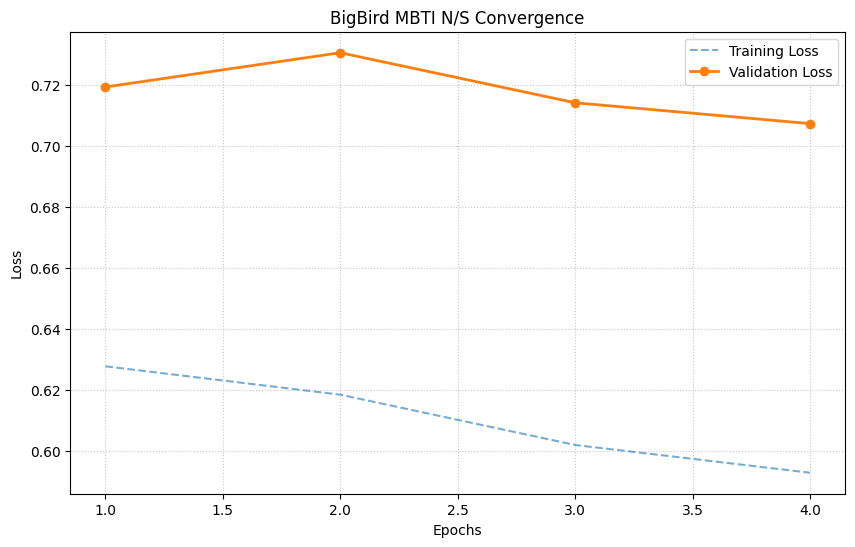

In [11]:
plot_loss(trainer_ns.state.log_history, title="BigBird MBTI N/S Convergence")